### Задача 1

Написать функцию для вычисления цены Европейского и Американского опционов в модели CRR (биномиальная модель).

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [155]:
def gen_lattice(S0, u, d, N, dt):
    """
    :param S0     начальное значение базового актива
    :param u      во сколько раз увеличится цена при движении вверх
    :param d      во сколько раз уменьшится цена при движении вниз
    :param N      число шагов в дереве
    :param dt     длительность одного уровня в дереве
    :return       решетка значений цены по от времени

    generates a binomial lattice

    for a given up, down, start value and number of steps (N).
    Resulting lattice has N+1 levels.
    """
    t = [0.]
    S = [float(S0)]

    for i in range(1, N+1):
        for j in range(0, i+1):
            t.append(dt*i)
            S.append( S0 * d**j * u**(i-j) )

    return np.array(t), np.array(S)


def model_params(r, T, sigma, N):
    """
    :param r       риск нейтральная ствавка
    :param T       общий временной промежуток
    :param sigma   волатильность на рынке
    :param N       число шагов биномиальной модели
    :return        dt - время одного шага,
                   df - фактор дисконтирвания,
                   u - во сколько раз изменится цена при движении вверх, 
                   d - во сколько раз изменится цена при движении вниз,
                   q - риск-нейтральная мера
    """


    # длительность одного шага
    dt = T / N
    # фактор дисконтирования
    df = np.exp(r * dt)


    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    q = ( np.exp(r * dt) - d ) / (u - d)

    return dt, df, u, d, q

from enum import Enum
class CallPut(Enum):
    call = 1
    put = 2

class ExerciseStyle(Enum):
    euro = 1
    amer = 2

In [156]:
def pot_tree(t, S):
    """
    функция рисует движение цены базового актива в биномиальной модели
    :param t   массив показвает, к какому временному промежутку относится точка
    :param S   значение цены базового актива
    """
    t = np.array(t)
    S = np.array(S)
    
    tmp = np.vstack((S, np.zeros(S.size)))
    
    for i in range(1, tmp.shape[1] - 1):
        if t[i] == t[i - 1] and t[i] == t[i + 1]:
             tmp[1, i] = -1

    plt.figure(figsize=(10, 8))
    plt.xlabel("Временной промежуток")
    plt.ylabel("Цена базового актива")
    plt.title("Зависимость цены базового актива от времени")

    for i in range(tmp.shape[1]):
        count = 0
        for j in range(i + 1, tmp.shape[1]):
            if tmp[0, j] != tmp[0, i]:
                if tmp[1, j] < 1:
                    plt.plot(t[np.array([i, j])], np.array([tmp[0, i], tmp[0, j]]), c = "black")
                    plt.scatter(t[np.array([i, j])], np.array([tmp[0, i], tmp[0, j]]), s=20, c = "blue")
                    tmp[1, j] += 1
                    count += 1
            if t[j] - t[i] > 1 or count == 2:
                break

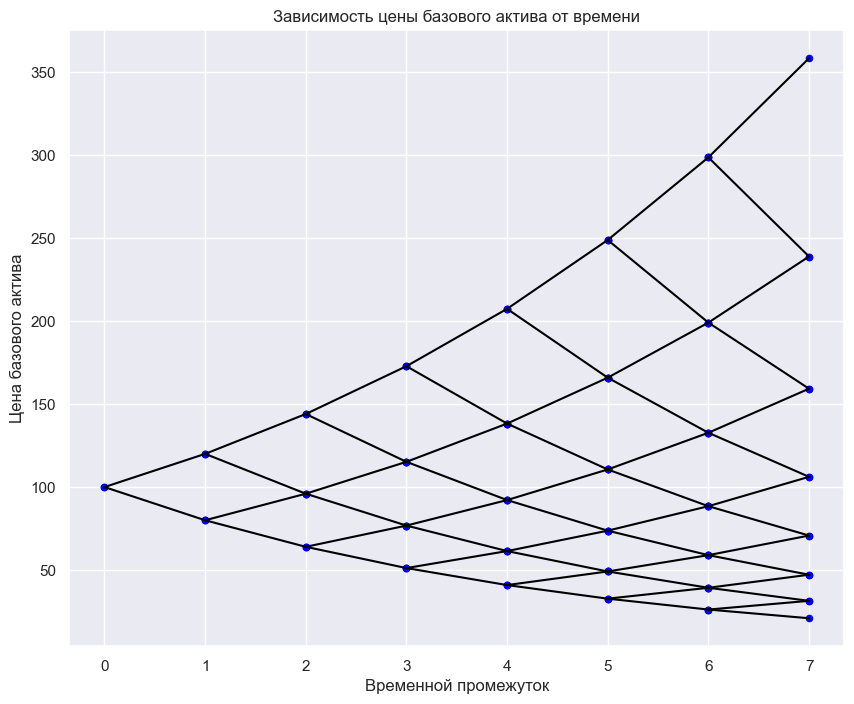

In [157]:
t, S = gen_lattice(100, 1.2, 0.8, 7, 1)
pot_tree(t, S)

In [159]:
def pv_crr(amerEuro, callPut, S0, K, T, r, sigma, N):
    """
    функция рассчитывает цены для put/call опционов изходя из payoff на последнем шаге бин. модели
    :param amerEuro    структура, определяющая тип опциона: американский/европейский 
    :param callPut     структура, определяющая тип опциона: put/call
    :param S0          начальная цена базового актива
    :param K           цена страйка
    :param T           время исполнения опциона
    :param r           безрисковая процентная ставка
    :param sigma       волатильность 
    :param N           сколько шагов в модели
    :return            цена опциона в начальный момент времени и динамика цены базового актива 
    """
    dt, df, u, d, q = model_params(r, T, sigma, N)

    _, S = gen_lattice(S0=S0, N=N, u=u, d=d, dt=dt)

    L = N+1

    def payoff(x):
        tmp = (x - K if CallPut.call == callPut else  K - x)
        tmp[tmp < 0] = 0
        return tmp

    # Calculate payoff at the last lattice level
    S = np.array(S)
    last_payoff = payoff(S[-L:])

    expected_price = last_payoff.copy()

    offset = 0
    while(True):
        expected_price = np.repeat(expected_price, 2)[1:-1]
        expected_price = expected_price.reshape((expected_price.size // 2, 2))
        expected_price = (expected_price[:, 0] * q + expected_price[:, 0] * (1 - q)) / (1 + r)
    
        offset += L
        L -= 1

        tmp_payoff = payoff(S[::-1][offset: offset+L][::-1])

        if amerEuro == ExerciseStyle.amer:
            tmp = np.vstack((expected_price, tmp_payoff))
            expected_price = np.max(tmp, axis=0)

        print("expected_price ", expected_price)
        print("expected payoff ", tmp_payoff)

        if expected_price.size == 1:
            break

    return expected_price, S

In [160]:
# parameters
S0 = 100.
T = 1.
r = 0.05
sigma = 0.20
K = 100.
N = 3


es = ExerciseStyle.euro
pvC, _ = pv_crr(es, CallPut.call, S0=S0, K=K, T=T, r=r, sigma=sigma, N=N)
print( pvC, _ )
pvP, _ = pv_crr(es, CallPut.put, S0=S0, K=K, T=T, r=r, sigma=sigma, N=N)
print( pvP, _ )



es = ExerciseStyle.amer
pvC, _ = pv_crr(es, CallPut.call, S0=S0, K=K, T=T, r=r, sigma=sigma, N=N)
print( pvC )
pvP, _ = pv_crr(es, CallPut.put, S0=S0, K=K, T=T, r=r, sigma=sigma, N=N)
print( pvP )

expected_price  [39.42690077 11.6572288   0.        ]
expected payoff  [25.97837858  0.          0.        ]
expected_price  [37.5494293  11.10212267]
expected payoff  [12.24009024  0.        ]
expected_price  [35.76136124]
expected payoff  [0.]
[35.76136124] [100.         112.24009024  89.09472523 125.97837858 100.
  79.37870064 141.39824581 112.24009024  89.09472523  70.72223522]
expected_price  [ 0.          0.         10.38597597]
expected payoff  [ 0.          0.         20.62129936]
expected_price  [0. 0.]
expected payoff  [ 0.         10.90527477]
expected_price  [0.]
expected payoff  [0.]
[0.] [100.         112.24009024  89.09472523 125.97837858 100.
  79.37870064 141.39824581 112.24009024  89.09472523  70.72223522]
expected_price  [39.42690077 11.6572288   0.        ]
expected payoff  [25.97837858  0.          0.        ]
expected_price  [37.5494293  11.10212267]
expected payoff  [12.24009024  0.        ]
expected_price  [35.76136124]
expected payoff  [0.]
[35.76136124]
expect